In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
import pandas as pd

%matplotlib inline

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os, pickle
import pickle

def cifar10(data_path):

    def _load_data_(files):
        X = np.empty([0, 3072])
        y = np.empty([0])
        for path in files:
            print(path)
            with open(path, "rb") as f:
                d = pickle.load(f, encoding='bytes')
                X = np.vstack([X, d[b"data"]]).astype("uint8")
                y = np.hstack([y, d[b"labels"]]).astype("uint8")
        return X, y
    
    training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
    test_files = [os.path.join(data_path, "test_batch")]
    labels_file = os.path.join(data_path, "batches.meta")

    X_train, y_train = _load_data_(training_files)
    X_test, y_test = _load_data_(test_files)

    X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
    X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255

    with open(labels_file, "rb") as f:
        labels = pickle.load(f, encoding="bytes")
    labels = [s.decode("utf-8")  for s in labels[b'label_names']]
    return X_train, X_test, y_train, y_test, labels

X_train, X_test, y_train, y_test, labels = cifar10("/data/cifar-10-batches-py/")
print("X_train:", X_train.shape, 
      "\nX_test:", X_test.shape, 
      "\ny_train: ", y_train.shape, 
      "\ny_test:", y_test.shape, 
      "\nlabels: ", labels)

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch
X_train: (50000, 32, 32, 3) 
X_test: (10000, 32, 32, 3) 
y_train:  (50000,) 
y_test: (10000,) 
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
Y_train = keras.utils.to_categorical(y_train)
Y_test = keras.utils.to_categorical(y_test)

In [9]:
tf.set_random_seed(1)
np.random.seed(1)
num_classes = len(labels)

def build_model(input_shape, num_classes):

    model = keras.Sequential()
    model.add(layers.Conv2D(activation="relu", 
                            filters=32, 
                            kernel_size=(5, 5), 
                            input_shape = input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(activation="relu", 
                        filters=64, 
                        kernel_size=(3, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    #model.add(layers.Dropout(rate=0.8))
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.compile(loss=keras.losses.categorical_crossentropy
                  , metrics=["accuracy"]
                  , optimizer="adam")
    return model

model = build_model(X_train.shape[1:], num_classes)
model.summary()

model.fit(x=X_train
          , y = Y_train
          , validation_data = (X_test, Y_test)
          , batch_size = 256
          , epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               230500    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1010      
Total para

In [81]:
model.layers[2].name

'conv2d_10'

In [11]:
conv1 = model.layers[0]

In [16]:
weights = conv1.get_weights()

In [18]:
weights[0].shape

(5, 5, 3, 32)

In [19]:
weights[1].shape

(32,)

In [29]:
weights[0].transpose(3, 0, 1, 2)[0][-1]

array([[-0.09122147, -0.0177708 , -0.04352054],
       [-0.04378188, -0.05659262, -0.0390413 ],
       [-0.09000023, -0.10043154, -0.06873843],
       [ 0.03959415, -0.13721609, -0.07685449],
       [ 0.0108302 , -0.03648832, -0.06850082]], dtype=float32)

In [88]:
model.layers

(1, 32, 32, 3)

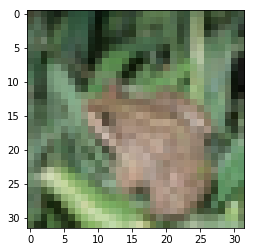

In [76]:
a = X_test[4:5]
plt.imshow(a[0])
a.shape

In [90]:
model.layers[0].name

'conv2d_9'

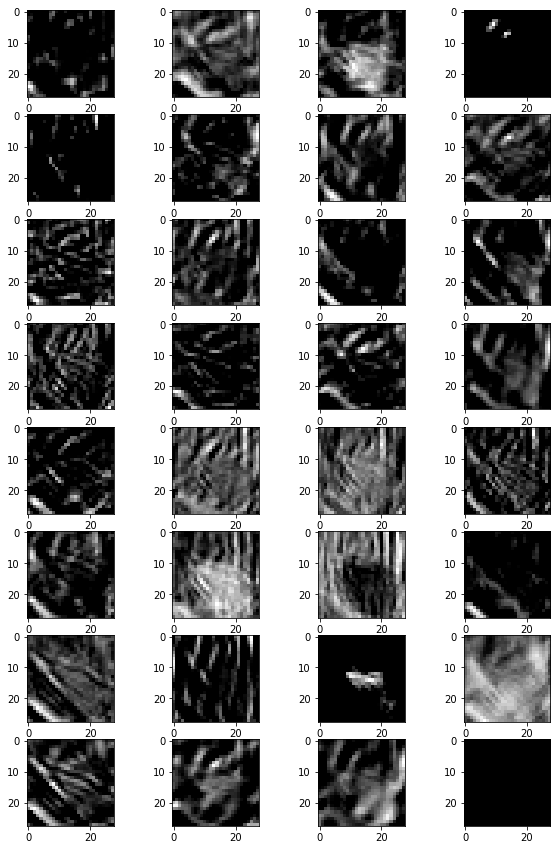

In [84]:
model3 = keras.Model(model.input, outputs=model.get_layer('conv2d_9').output)
a_layer1_out = model3.predict(a)[0]

fig, _ = plt.subplots(8, 4, figsize = (10, 15))
for i, ax in enumerate(fig.axes):
    ax.imshow(a_layer1_out[:,:, i], cmap = "gray")

(12, 12, 64)


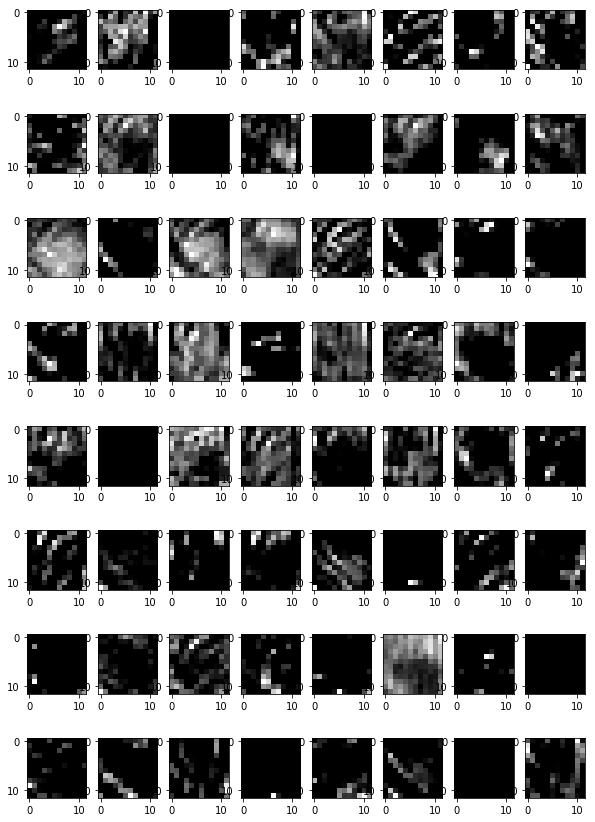

In [87]:
model3 = keras.Model(model.input, outputs=model.get_layer('conv2d_10').output)
a_layer2_out = model3.predict(a)[0]
print(a_layer2_out.shape)

fig, _ = plt.subplots(8, 8, figsize = (10, 15))
for i, ax in enumerate(fig.axes):
    ax.imshow(a_layer2_out[:,:, i], cmap = "gray")

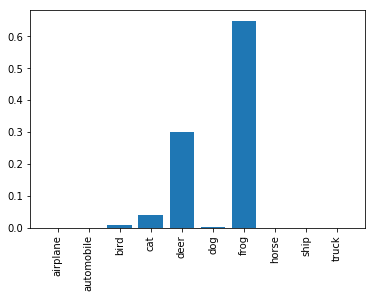

In [98]:
plt.bar(range(10), model.predict(a)[0])
plt.xticks(range(10), labels, rotation = "90");